# Introduction

This notebook provides a guide to using scRNA-seq data. It demonstrates how to load, preprocess, and analyze multimodal imaging data, enabling exploration of single cell resolved cell types and their associated features.

The workflow includes downloading datasets, applying dimensionality reduction techniques like PCA and UMAP, and applying annotations. Visualization methods are showcased, including UMAP and pie plots.

## Download the preprocessed data from the given URL

To get started, download the datasets (~0.8 GB) from the provided Zenodo repository, then extract (unpack) 
the contents to a local directory on your machine. After unpacking, locate the variable named dataPath 
in the cell below and update its value to point to the folder where you extracted the data. Once you've 
set the correct path, you can run the subsequent cells to visualize the data.

In [1]:
import os
import pandas as pd
import numpy as np
import scanpy as sc
from scanpy import external as sce
from scanpy.tools._score_genes import score_genes
import matplotlib
from matplotlib import cm
from matplotlib.patheffects import withStroke
from matplotlib import pyplot as plt
import urllib.request
import zipfile

def downloadFromZenodo(targetDir, url, zip_file='dataset.zip'):
    
    """Download the dataset from Zenodo and extracts it to the specified directory."""

    if not os.path.isdir(targetDir):
        def reporthook(a, b, c):
            print(f"\rDownloading: {(a * b) // 1024**2} MB", end='')
        urllib.request.urlretrieve(url, zip_file, reporthook)
        print()
        os.makedirs(targetDir, exist_ok=True)
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(targetDir)
        os.remove(zip_file)
        print(f"Downloaded and extracted dataset into '{targetDir}'.")
    else:
        print(f"Directory '{targetDir}' already exists. Skipping download.")
    return

In [2]:
dataPath = './'

In [3]:
dataSubScRNA = "scrna-PL006"
url = "https://zenodo.org/api/records/16904095/files-archive"
downloadFromZenodo(os.path.join(dataPath, dataSubScRNA), url)

Directory '/projects/activities/kappsen-tmc/USERS/domans/examples-sennet-portal/scrna-PL006' already exists. Skipping download.


# Code used to preprocess the data

The code load the three datasets and preprocess them is provided below for reference. The code is set to load filtered **`h5`** files from 10x Genomics Cell Ranger quantification.<br>
The datasets are concatenated, normalized, clustered abnd saved in **`h5ad`** format.

SenNet IDs used in this example:<br>
`SNT268.LXPG.784` 'PL0006PADISNR'<br>
`SNT324.BDTT.263` 'PL0006PADDU'<br>
`SNT469.JJLS.674` 'PL0006PADAC'<br>

In [4]:
if False:
    from scipy.sparse import csr_matrix

    getOne = lambda p: sc.read_10x_h5(f'scRNA/PL0006PAD{p}_sample_filtered_feature_bc_matrix.h5').to_df().astype(int).groupby(level=0, axis=1).sum()

    ad = sc.concat([getOne() for p in ['DU', 'ISNR', 'AC']], axis=0)
    ad.X = csr_matrix(ad.X.astype(int))
    ad.obs['case'] = 'SC2300734_PL0006PAD'
    ad.obs['sample'] = ['DU']*ad1.shape[0] +  ['ISNR']*ad2.shape[0] +  ['DAC']*ad3.shape[0]

    # Filter out low-quality cells and genes with less than 200 genes expressed
    sc.pp.filter_cells(adata, min_genes=200)

    # Filter out genes expressed in less than 3 cells
    sc.pp.filter_genes(adata, min_cells=3)

    # Compute QC metrics
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)

    # Filter out cells with high mitochondrial gene expression
    adata = adata[adata.obs.pct_counts_mt < 5, :]

    # Normalize and log-transform the data
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

    # Identify highly variable genes
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

    # Store the raw data for later use
    adata.raw = adata
    adata = adata[:, adata.var.highly_variable]

    # Regress out unwanted sources of variation using only the highly variable genes
    sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])
    sc.pp.scale(adata, max_value=10)

    # Perform PCA with 40 components and correct for batch effects using Harmony
    sc.tl.pca(adata, n_comps=40)
    sce.pp.harmony_integrate(adata, 'sample', lamb=0.5)

    # Compute neighborhood graph and UMAP
    sc.pp.neighbors(adata, use_rep='X_pca_harmony', n_neighbors=10)
    sc.tl.umap(adata)

    # Cluster the cells using Leiden algorithm
    sc.tl.leiden(adata, key_added='cluster', resolution=0.2)

    # Specify that natural logarithm was used for log transformation
    adata.uns['log1p']["base"] = None

    # Save the processed clustered AnnData object
    adata.write('SC2300734-PL0006PAD-clustered.h5ad')

# Visualize and annotate clusters

In [5]:
adata = sc.read(os.path.join(dataPath, dataSubScRNA, 'SC2300734-PL0006PAD-clustered.h5ad'))

In [6]:
# plt.rcParams['figure.dpi'] = 150

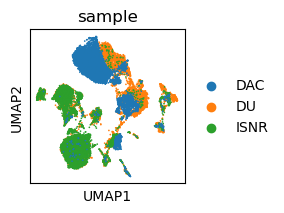

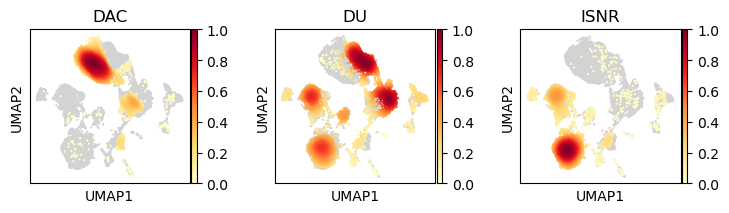

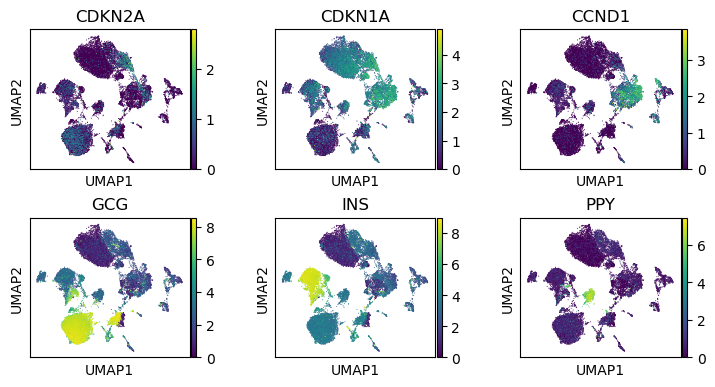

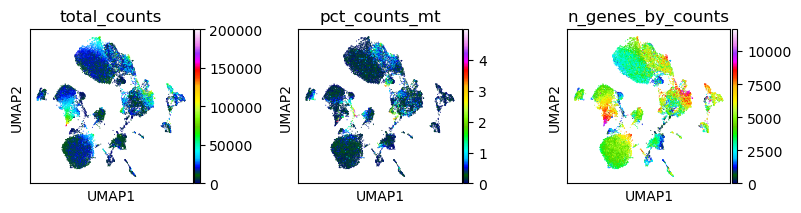

In [7]:
plt.rcParams["figure.figsize"] = (2, 2)
sc.pl.umap(adata, color='sample')

sc.tl.embedding_density(adata, basis='umap', groupby='sample')
sc.pl.embedding_density(adata, basis='umap', key='umap_density_sample', s=10)

sc.pl.umap(adata, color=["CDKN2A", "CDKN1A", 'CCND1', "GCG", "INS", "PPY"], use_raw=True, ncols=3, s=2, hspace=0.35)

sc.pl.umap(adata, color=['total_counts', 'pct_counts_mt', 'n_genes_by_counts'], use_raw=True, ncols=3, cmap='gist_ncar', vmin=0, wspace=0.5, s=2)

## Display the clusters on UMAP

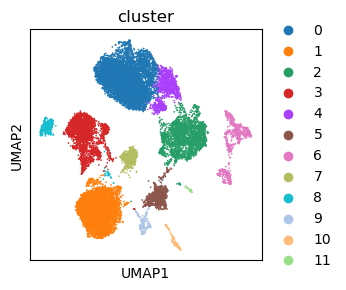

In [8]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata, color='cluster')

## Apply pre-defined annotation of the clusters

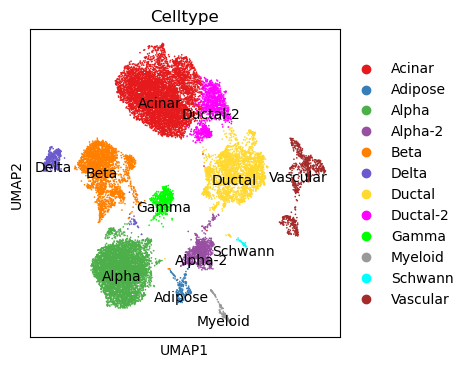

In [9]:
celltypemap = {'0': 'Acinar',
             '1': 'Alpha',
             '2': 'Ductal',
             '3': 'Beta',
             '4': 'Ductal-2',
             '5': 'Alpha-2',
             '6': 'Vascular',
             '7': 'Gamma',
             '8': 'Delta',
             '9': 'Adipose',
             '10': 'Myeloid',
             '11': 'Schwann'}

adata.obs['Celltype'] = adata.obs['cluster'].astype(str).replace(celltypemap).astype(str).astype('category')

palette={celltype: cm.Set1(k) for k, celltype in enumerate(sorted(list(set(celltypemap.values()))))}
palette.update({'Ductal': cm.Set2(5), 'Vascular': 'brown', 'Schwann': 'cyan', 'Ductal-2': 'magenta', 'Delta': 'slateblue', 'Gamma': 'lime'})

fig, ax = plt.subplots(figsize=(4, 4))
sc.pl.umap(adata, color='Celltype', palette=palette, ax=ax, show=False)
for c in adata.obs['Celltype'].unique():
    x, y = np.median(adata.obsm['X_umap'][(adata.obs['Celltype']==c).values, :], axis=0)
    ax.text(x, y, c, ha='center', va='top', fontsize=10, weight='normal')
plt.show()

## Explore cluster gene expression of selected genes

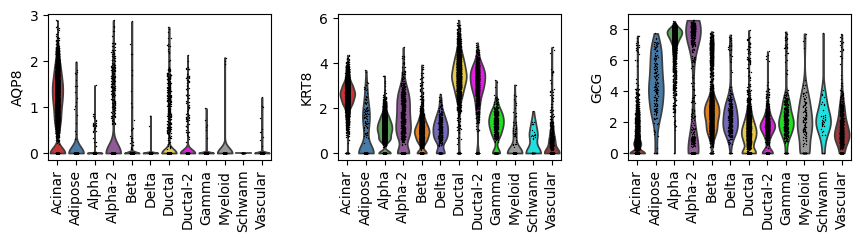

In [10]:
plt.rcParams["figure.figsize"] = (3.5, 2)
sc.pl.violin(adata, keys=['AQP8', 'KRT8', 'GCG'], groupby='Celltype', rotation=90)

# Compute SenMayo gene list score

In [11]:
SenMayoGenes = ['ACVR1B', 'ANG', 'ANGPT1', 'ANGPTL4', 'AREG', 'AXL', 'BEX3', 'BMP2', 'BMP6', 'C3', 'CCL1', 'CCL13', 'CCL16', 'CCL2', 
                'CCL20', 'CCL24', 'CCL26', 'CCL3', 'CCL3L1', 'CCL4', 'CCL5', 'CCL7', 'CCL8', 'CD55', 'CD9', 'CSF1', 'CSF2', 'CSF2RB', 'CST4', 
                'CTNNB1', 'CTSB', 'CXCL1', 'CXCL10', 'CXCL12', 'CXCL16', 'CXCL2', 'CXCL3', 'CXCL8', 'CXCR2', 'DKK1', 'EDN1', 'EGF', 'EGFR', 
                'EREG', 'ESM1', 'ETS2', 'FAS', 'FGF1', 'FGF2', 'FGF7', 'GDF15', 'GEM', 'GMFG', 'HGF', 'HMGB1', 'ICAM1', 'ICAM3', 'IGF1', 
                'IGFBP1', 'IGFBP2', 'IGFBP3', 'IGFBP4', 'IGFBP5', 'IGFBP6', 'IGFBP7', 'IL10', 'IL13', 'IL15', 'IL18', 'IL1A', 'IL1B', 'IL2', 
                'IL32', 'IL6', 'IL6ST', 'IL7', 'INHA', 'IQGAP2', 'ITGA2', 'ITPKA', 'JUN', 'KITLG', 'LCP1', 'MIF', 'MMP1', 'MMP10', 'MMP12', 
                'MMP13', 'MMP14', 'MMP2', 'MMP3', 'MMP9', 'NAP1L4', 'NRG1', 'PAPPA', 'PECAM1', 'PGF', 'PIGF', 'PLAT', 'PLAU', 'PLAUR', 'PTBP1', 
                'PTGER2', 'PTGES', 'RPS6KA5', 'SCAMP4', 'SELPLG', 'SEMA3F', 'SERPINB4', 'SERPINE1', 'SERPINE2', 'SPP1', 'SPX', 'TIMP2', 'TNF', 
                'TNFRSF10C', 'TNFRSF11B', 'TNFRSF1A', 'TNFRSF1B', 'TUBGCP2', 'VEGFA', 'VEGFC', 'VGF', 'WNT16', 'WNT2']

score_genes(adata, gene_list=adata.var.index.intersection(SenMayoGenes), score_name='SenMayo', ctrl_size=50)

In [12]:
# Filter out cells that are not of interest
adata = adata[~adata.obs['Celltype'].isin(['Alpha-2'])]

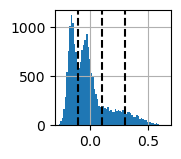

In [13]:
# Define bins for analysis
bins = [-0.1, 0.1, 0.3]

fig, ax = plt.subplots(figsize=(1.5, 1.5))
adata.obs['SenMayo'].hist(bins=100, ax=ax)
ax.set_xlim([-0.3, 0.7])
for bin in bins:
    plt.axvline(bin, linestyle='--', c='k')

In [14]:
se = adata.obs['SenMayo'].copy()
adata.obs['SenMayo-bin'] = 'Bin 0'
for ibin, bin in enumerate(bins):
    adata.obs.loc[se>=bin, 'SenMayo-bin'] = 'Bin %s' % (ibin+1)
adata.obs.loc[:, 'SenMayo-bin'] = adata.obs.loc[:, 'SenMayo-bin'].astype('category')

/tmp/ipykernel_973799/3630887925.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['SenMayo-bin'] = 'Bin 0'


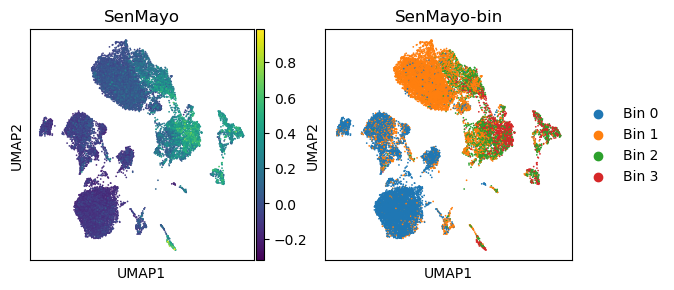

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3))
sc.pl.umap(adata, color=['SenMayo'], show=False, cmap='viridis', ax=axs[0])
sc.pl.umap(adata, color=['SenMayo-bin'], show=False, cmap='viridis', ax=axs[1])
plt.show()

## View cell type composition in each SenMayo score bin

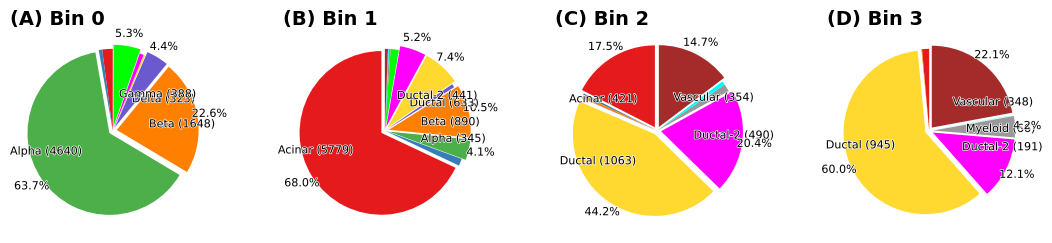

In [16]:
fig, axs = plt.subplots(1, 4, figsize=(4*2.75, 2.5))
params = dict(pctdistance=1.15, labeldistance=.4, textprops=dict(fontsize=8))
identity = 'SenMayo-bin'
panels = ['A', 'B', 'C', 'D']
for i, val in enumerate(['Bin 0', 'Bin 1', 'Bin 2', 'Bin 3']):
    wh = adata.obs[identity].replace('', 'Unknown')==val
    se = adata.obs.loc[wh, 'Celltype'].value_counts()
    se = se.sort_index()
    sizes = se.values
    labels = [f'{ct} ({size})' if size/sizes.sum() > 0.025 else '' for ct, size in zip(se.index, sizes)]
    explode = [0.05 if size/sizes.sum() > 0.025 else 0 for size in sizes]
    colors = [palette[ct] for ct in se.index]
    ax = axs[i]
    wedges, texts, autotexts = ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct=lambda pct: f'{pct:.1f}%' if pct > 2.5 else '',
                                    shadow=False, startangle=90, **params)
    for text in texts + autotexts:
        text.set_path_effects([withStroke(linewidth=1, foreground='white')])
    axs[i].text(axs[i].get_xlim()[0], axs[i].get_ylim()[1], f'({panels[i]}) {val}', ha='left', va='bottom', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()
